# UTKFace
- https://susanqq.github.io/UTKFace/

The labels of each face image is embedded in the file name, formated like `[age]_[gender]_[race]_[date&time].jpg`

- `[age]` is an integer from 0 to 116, indicating the age
- `[gender]` is either 0 (male) or 1 (female)
- `[race]` is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
- `[date&time]` is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [ ]:
id2gender = {
    0: 'male',
    1: 'female'
}

In [ ]:
import kagglehub
dataroot = kagglehub.dataset_download('jangedoo/utkface-new')

In [ ]:
from pathlib import Path

In [ ]:
dataroot = Path(dataroot)

In [ ]:
files = sorted((dataroot / 'UTKFace').glob("*.jpg"))
len(files)

23708

In [ ]:
files_part = sorted((dataroot / 'crop_part1').glob("*.jpg"))
len(files_part)

9780

In [ ]:
duplicates = set([f.name for f in files]) & set([f.name for f in files_part])
len(duplicates)

9779

In [ ]:
set([f.name for f in files_part]) - set(duplicates)

{'61_3_20170109150557335.jpg.chip.jpg'}

In [ ]:
f = files[0]
f.name

'100_0_0_20170112213500903.jpg.chip.jpg'

In [ ]:
type(f.name)

str

In [ ]:
parts = f.name.split('.')[0].split('_')
parts

['100', '0', '0', '20170112213500903']

In [ ]:
str(f.resolve())

'/home/usr/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg'

In [ ]:
def parse_filename(f):
    parts = f.name.split('.')[0].split('_')
    age = int(parts[0])
    gender = int(parts[1])
    return str(f.resolve()), age, gender

In [ ]:
data = [parse_filename(f) for f in files_part]

In [ ]:
data[:10]

[('/home/usr/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/crop_part1/100_1_0_20170110183726390.jpg.chip.jpg',
  100,
  1),
 ('/home/usr/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/crop_part1/100_1_2_20170105174847679.jpg.chip.jpg',
  100,
  1),
 ('/home/usr/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/crop_part1/101_1_2_20170105174739309.jpg.chip.jpg',
  101,
  1),
 ('/home/usr/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/crop_part1/10_0_0_20161220222308131.jpg.chip.jpg',
  10,
  0),
 ('/home/usr/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/crop_part1/10_0_0_20170103200329407.jpg.chip.jpg',
  10,
  0),
 ('/home/usr/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/crop_part1/10_0_0_20170103200522151.jpg.chip.jpg',
  10,
  0),
 ('/home/usr/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/crop_part1/10_0_0_20170103233459275.jpg.chip.jpg',
  10,
  0),
 ('/home/usr/.cache/kagglehub/datasets/jangedoo/utkface-

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(data, columns=['file', 'age', 'gender'])
df

,file,age,gender
0,/home/usr/.cache/kagglehub/datasets/jangedoo/u...,100,1
1,/home/usr/.cache/kagglehub/datasets/jangedoo/u...,100,1
2,/home/usr/.cache/kagglehub/datasets/jangedoo/u...,101,1
3,/home/usr/.cache/kagglehub/datasets/jangedoo/u...,10,0
4,/home/usr/.cache/kagglehub/datasets/jangedoo/u...,10,0
...,...,...,...
9775,/home/usr/.cache/kagglehub/datasets/jangedoo/u...,9,1
9776,/home/usr/.cache/kagglehub/datasets/jangedoo/u...,9,1
9777,/home/usr/.cache/kagglehub/datasets/jangedoo/u...,9,1
9778,/home/usr/.cache/kagglehub/datasets/jangedoo/u...,9,1


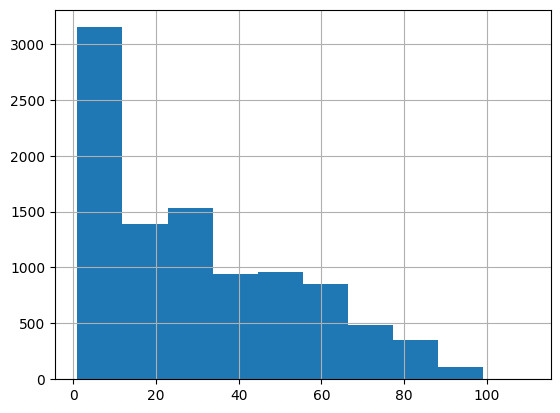

In [ ]:
df['age'].hist();

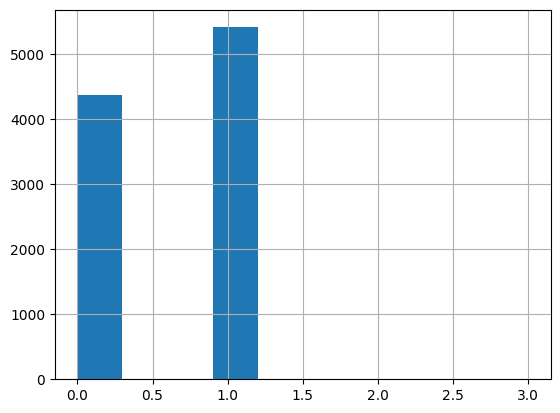

In [ ]:
df['gender'].hist();

In [ ]:
len(df)

9780

In [ ]:
idx = 0
sample = df.iloc[idx]
sample

file      /home/usr/.cache/kagglehub/datasets/jangedoo/u...
age                                                     100
gender                                                    1
Name: 0, dtype: object

In [ ]:
file = sample['file']
age = sample['age']
gender = sample['gender']
print(file, age, gender)

/home/usr/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/crop_part1/100_1_0_20170110183726390.jpg.chip.jpg 100 1


In [ ]:
import torch

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class GenderAgeClass(Dataset):
  def __init__(self, df, transform=None):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    sample = self.df.iloc[idx]
    age = torch.Tensor([float(sample['age']/100)])
    gender = torch.Tensor([int(sample['gender'])])
    image = Image.open(sample['file'])
    if self.transform:
      image = self.transform(image)
    return image, age, gender

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [ ]:
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import timm

In [ ]:
model = timm.create_model("vgg16", pretrained=True).to(device)
data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
transform = timm.data.create_transform(**data_cfg)

In [ ]:
train_dataset = GenderAgeClass(train_df, transform=transform)
val_dataset = GenderAgeClass(val_df, transform=transform)

In [ ]:
spl = train_dataset[0]
spl[0].shape, spl[1], spl[2]

(torch.Size([3, 224, 224]), tensor([0.0800]), tensor([1.]))

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, drop_last=False)

In [ ]:
batch = next(iter(train_loader))
img, age, gender = batch
img, age, gender = img.to(device), age.to(device), gender.to(device)
img.shape, age.shape, gender.shape

(torch.Size([2, 3, 224, 224]), torch.Size([2, 1]), torch.Size([2, 1]))

In [ ]:
img.dtype, age.dtype, gender.dtype

(torch.float32, torch.float32, torch.float32)

In [ ]:
model(img).shape

torch.Size([2, 1000])

In [ ]:
model.forward_features(img).shape

torch.Size([2, 512, 7, 7])

In [ ]:
model.features(img).shape

torch.Size([2, 512, 7, 7])

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from torch import nn

In [ ]:
class ageGenderClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.intermediate = nn.Sequential(
            nn.Linear(4096,512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128,64),
            nn.ReLU(),
        )
        self.age_classifier = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        self.gender_classifier = nn.Sequential(
            nn.Linear(64, 1),
        )
    def forward(self, x):
        x = self.intermediate(x)
        age = self.age_classifier(x)
        gender = self.gender_classifier(x)
        return age, gender

In [ ]:
model.head.fc = ageGenderClassifier()

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model = model.to(device)

In [ ]:
age_pred, gender_pred = model(img)
age_pred.shape, gender_pred.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [ ]:
import numpy as np

In [ ]:
age

tensor([[0.4900],
        [0.4000]], device='cuda:0')

In [ ]:
age_pred

tensor([[0.4991],
        [0.4955]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
(age*100).type(torch.int)

tensor([[49],
        [40]], device='cuda:0', dtype=torch.int32)

In [ ]:
(age_pred*100).type(torch.int)

tensor([[49],
        [49]], device='cuda:0', dtype=torch.int32)

In [ ]:
torch.abs((age*100).type(torch.int) - (age_pred*100).type(torch.int)).float().mean()

tensor(4.5000, device='cuda:0')

In [ ]:
gender

tensor([[1.],
        [0.]], device='cuda:0')

In [ ]:
gender_pred

tensor([[0.0631],
        [0.0454]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
from torch.nn.functional import sigmoid

In [ ]:
sigmoid(gender_pred)

tensor([[0.5158],
        [0.5114]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
(sigmoid(gender_pred)>0.5).type(torch.float)

tensor([[1.],
        [1.]], device='cuda:0')

In [ ]:
(gender == (sigmoid(gender_pred)>0.5).type(torch.float)).float().mean()

tensor(0.5000, device='cuda:0')

In [ ]:
age_criterion = nn.L1Loss()
gender_criterion = nn.BCEWithLogitsLoss()

In [ ]:
age_criterion(age_pred, age)

tensor(0.0523, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
gender_criterion(gender_pred, gender)

tensor(0.6891, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
from tqdm import tqdm
import pickle
from torch.optim import Adam

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("vgg16", pretrained=True)
data_cfg = timm.data.resolve_data_config(model.pretrained_cfg)
transform = timm.data.create_transform(**data_cfg)
for param in model.parameters(): 
    param.requires_grad = False
model.head.fc = ageGenderClassifier()
model = model.to(device)

In [ ]:
from torchinfo import summary

In [ ]:
summary(model, input_data=img)

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [2, 1]                    --
├─Sequential: 1-1                        [2, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [2, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [2, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [2, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [2, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [2, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [2, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [2, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [2, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [2, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [2, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [2, 256, 56, 56]    

In [ ]:
optimizer = Adam(model.parameters(), lr=1e-4)

In [ ]:
train_dataset = GenderAgeClass(train_df, transform=transform)
val_dataset = GenderAgeClass(val_df, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, drop_last=False)

age_criterion = nn.L1Loss()
gender_criterion = nn.BCEWithLogitsLoss()

In [ ]:
train_losses = []
val_losses = []
val_age_maes = []
val_gender_accuracies = []

loss_val_best = 1e3

n_epochs = 5
for epoch in range(n_epochs):
    print("Epoch", epoch)
    model.train()
    loss_train = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        img, age, gender = batch
        img, age, gender = img.to(device), age.to(device), gender.to(device)
        age_pred, gender_pred = model(img)
        age_loss = age_criterion(age_pred, age)
        gender_loss = gender_criterion(gender_pred, gender)
        total_loss = gender_loss + age_loss
        total_loss.backward()
        optimizer.step()
        
        loss_train += total_loss.item()
    loss_train /= len(train_loader)
    train_losses.append(loss_train)

    model.eval()
    loss_val = 0
    age_mae_val = 0
    gender_accuracy_val = 0
    for batch in tqdm(val_loader):
        img, age, gender = batch
        img, age, gender = img.to(device), age.to(device), gender.to(device)
        with torch.inference_mode():
            age_pred, gender_pred = model(img)
        age_loss = age_criterion(age_pred, age)
        gender_loss = gender_criterion(gender_pred, gender)
        total_loss = gender_loss + age_loss
        loss_val += total_loss.item()
        
        true_age = (age*100).type(torch.int)
        pred_age = (age_pred*100).type(torch.int)
        age_mae_val += torch.abs(true_age-pred_age).float().mean().item()

        pred_gender = (sigmoid(gender_pred)>0.5).type(torch.float)
        gender_accuracy_val += (gender == pred_gender).float().mean().item()
    loss_val /= len(val_loader)    
    age_mae_val /= len(val_loader)
    gender_accuracy_val /= len(val_loader)
    val_losses.append(loss_val)
    val_age_maes.append(age_mae_val)
    val_gender_accuracies.append(gender_accuracy_val)

    if loss_val < loss_val_best:
        print(f'{loss_val_best} -> {loss_val}')
        loss_val_best = loss_val
        torch.save(model.state_dict(), 'best_model.pt')

    results = {
        'train_losses':train_losses,
        'val_losses':val_losses,
        'val_age_maes':val_age_maes,
        'val_gender_accuracies':val_gender_accuracies,
    }
    with open('results.pkl', 'wb') as f:
        pickle.dump(results, f)

Epoch 0


100%|██████████| 92/92 [00:08<00:00, 10.66it/s]


1000.0 -> 0.5823006014461103
Epoch 1


100%|██████████| 92/92 [00:08<00:00, 11.11it/s]


0.5823006014461103 -> 0.5493229627609253
Epoch 2


100%|██████████| 92/92 [00:08<00:00, 10.58it/s]


Epoch 3


100%|██████████| 92/92 [00:08<00:00, 10.75it/s]


0.5493229627609253 -> 0.530601939915315
Epoch 4


100%|██████████| 92/92 [00:08<00:00, 10.24it/s]


0.530601939915315 -> 0.5181273100492747


In [ ]:
with open('results.pkl', 'rb') as f:
    res = pickle.load(f)

In [ ]:
import matplotlib.pyplot as plt

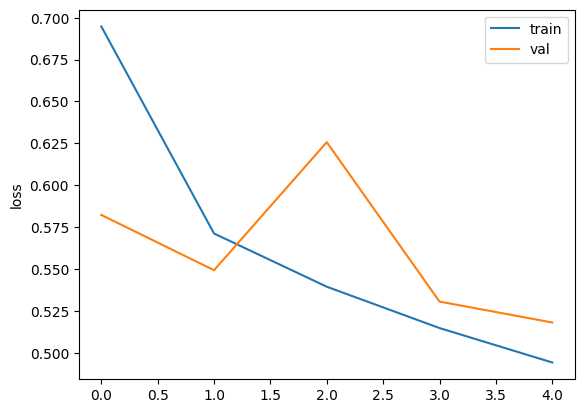

In [ ]:
plt.plot(res['train_losses'], label='train')
plt.plot(res['val_losses'], label='val')
plt.ylabel('loss')
plt.legend();

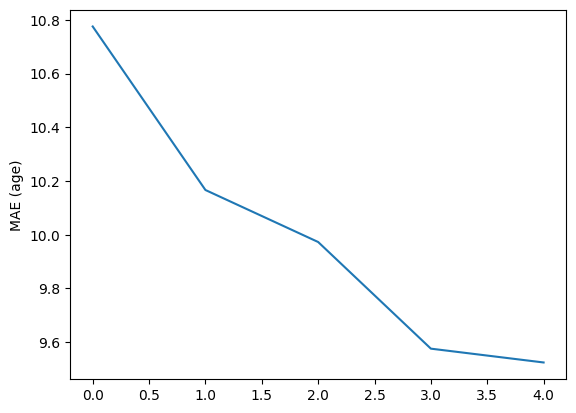

In [ ]:
plt.plot(res['val_age_maes'])
plt.ylabel('MAE (age)');

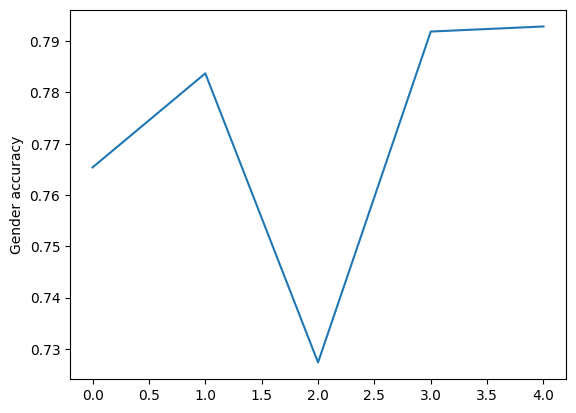

In [ ]:
plt.plot(res['val_gender_accuracies'])
plt.ylabel('Gender accuracy');

In [ ]:
model.load_state_dict(torch.load('best_model.pt', map_location=device, weights_only=True))

<All keys matched successfully>

In [ ]:
test_dataset = GenderAgeClass(test_df, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=False)

model.eval()
loss_test = 0
age_mae_test = 0
gender_accuracy_test = 0
for batch in tqdm(test_loader):
    img, age, gender = batch
    img, age, gender = img.to(device), age.to(device), gender.to(device)
    with torch.inference_mode():
        age_pred, gender_pred = model(img)
    age_loss = age_criterion(age_pred, age)
    gender_loss = gender_criterion(gender_pred, gender)
    total_loss = gender_loss + age_loss
    loss_test += total_loss.item()
    
    true_age = (age*100).type(torch.int)
    pred_age = (age_pred*100).type(torch.int)
    age_mae_test += torch.abs(true_age-pred_age).float().mean().item()

    pred_gender = (sigmoid(gender_pred)>0.5).type(torch.float)
    gender_accuracy_test += (gender == pred_gender).float().mean().item()
loss_test /= len(test_loader)    
age_mae_test /= len(test_loader)
gender_accuracy_test /= len(test_loader)

print("test loss", loss_test)
print("MAE (age)", age_mae_test)
print("Gender accuracy", gender_accuracy_test)

100%|██████████| 92/92 [00:09<00:00,  9.86it/s]

test loss 0.5046443884139475
MAE (age) 9.088253461796304
Gender accuracy 0.8047183797411297


In [ ]:
test_dataset = GenderAgeClass(test_df)

In [ ]:
len(test_df)

1467

Age
True: 25
Pred: 26

Gender
True: female
Pred: female


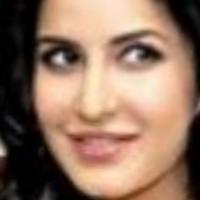

In [ ]:
idx = np.random.choice(len(test_df))
sample = test_dataset[idx]
img, age, gender = sample

age_pred, gender_pred = model(transform(img).to(device).unsqueeze(0))
true_age = (age*100).type(torch.int).item()
pred_age = (age_pred*100).type(torch.int).item()

true_gender = id2gender[gender.item()]
pred_gender = id2gender[(sigmoid(gender_pred)>0.5).type(torch.float).item()]
print("Age")
print(f"True: {true_age}")
print(f"Pred: {pred_age}")
print()
print("Gender")
print(f"True: {true_gender}")
print(f"Pred: {pred_gender}")
img